In [1]:
import sys

import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC

In [2]:
connection = mysql.connector.connect(host='localhost', database='offerusers', user='root', password='Capstone')

In [3]:
# ----- Function to update the product database based on the decision -----
def db_update(DecisionCode, prdID):
    mycursor = connection.cursor()
    if DecisionCode == "Approved":
        sql = "UPDATE offerusers.all_requests SET m_decision=1 WHERE (m_decision=9)"
        sql_dec = "UPDATE offerusers.request SET req_decision=%s WHERE (productID=%s);"
    else:
        sql = "UPDATE offerusers.all_requests SET m_decision=0 WHERE (m_decision=9)"
        sql_dec = "UPDATE offerusers.request SET req_decision=%s WHERE (productID=%s);"
    # mycursor.execute(sql)
    val = (DecisionCode, prdID)
    mycursor.execute(sql_dec, val)
    connection.commit()
    print(mycursor.rowcount, "record(s) updated")

In [4]:
# ----- Read the txt file and store results to a data frame -----
df_os = pd.read_sql('SELECT * FROM offerusers.all_requests where m_decision!=9', con=connection)
df_new = pd.read_sql('SELECT * FROM offerusers.all_requests where m_decision=9', con=connection)
df_preserve = pd.read_sql('SELECT * FROM offerusers.all_requests where m_decision=9', con=connection)

In [5]:
if df_new.empty:
    print("No product request for decisioning...")
    sys.exit()

In [6]:
print(df_os.head(5))

     prodid  b_market_price  c_requested_price  d_locationzip  \
0     Book1           100.0              200.0          84095   
1     Bread            10.0                8.0          95095   
2       Car         30000.0            28000.0          76543   
3     Flask            20.0               15.0          87087   
4  Garments            50.0               45.0          87087   

  e_product_demand  f_nbrof_req  g_req_credibility h_offer_by_others  \
0             High          550                  7                 Y   
1             High         1000                  9                 Y   
2              Low            8                  9                 N   
3              Low           10                  3                 N   
4           Medium           20                  6                 N   

   i_revenue_opportunity j_merchant_alignments k_basic_vs_non  \
0                      8                     N          Basic   
1                      2                     Y

In [7]:
# ----- Perform basic validations on the dataset -----
print("Shape is : \n", df_os.shape)
print("Data Types are : \n", df_os.dtypes)
print("Null rows count is : \n", df_os.isnull().sum())

Shape is : 
 (17, 13)
Data Types are : 
 prodid                    object
b_market_price           float64
c_requested_price        float64
d_locationzip              int64
e_product_demand          object
f_nbrof_req                int64
g_req_credibility          int64
h_offer_by_others         object
i_revenue_opportunity      int64
j_merchant_alignments     object
k_basic_vs_non            object
l_last12mnts_offer        object
m_decision                 int64
dtype: object
Null rows count is : 
 prodid                   0
b_market_price           0
c_requested_price        0
d_locationzip            0
e_product_demand         0
f_nbrof_req              0
g_req_credibility        0
h_offer_by_others        0
i_revenue_opportunity    0
j_merchant_alignments    0
k_basic_vs_non           0
l_last12mnts_offer       0
m_decision               0
dtype: int64


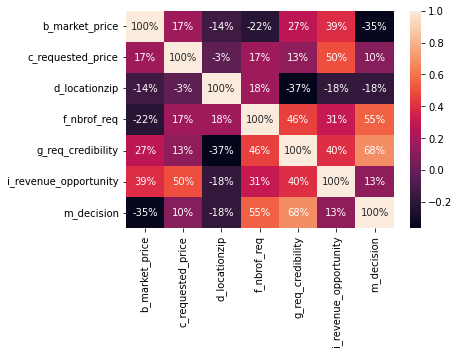

In [9]:
# ----- Visualize the correlations between the categorical variables -----
sns.heatmap(df_os.corr(), annot=True, fmt='.0%')
plt.show()

In [10]:
# ----- Feature selection for baseline records -----
categorical_var = list(df_os.dtypes.loc[df_os.dtypes == 'object'].index)
for var in categorical_var:
    df_os[var] = df_os[var].astype('category')
df_os[categorical_var] = df_os[categorical_var].apply(lambda x: x.cat.codes)

In [11]:
# ----- Feature selection for new record -----
categorical_var = list(df_new.dtypes.loc[df_new.dtypes == 'object'].index)
for var in categorical_var:
    df_new[var] = df_new[var].astype('category')
df_new[categorical_var] = df_new[categorical_var].apply(lambda x: x.cat.codes)

In [12]:
# ----- Extract the dependent and independent variables -----
X = df_os.iloc[:, :-1].values
X_new = df_new.iloc[:, :-1].values
y = df_os.iloc[:, 12].values

In [13]:
# ----- Splitting dataset into training and test data -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [14]:
# ----- Bagging classifier -----
model_bg = BaggingClassifier()
model_bg.fit(X_train, y_train)
bagging_score = model_bg.score(X_test, y_test)

In [15]:
print("Bagging Classifier Score is: ", bagging_score)

Bagging Classifier Score is:  0.8


In [16]:
# ----- Boosting classifier -----
model_xgb = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=5000,
                              subsample=0.5, colsample_bytree=0.5, eval_metric='auc', verbosity=1)
model_xgb.fit(X_train, y_train)
boosting_score = model_xgb.score(X_test, y_test)

In [17]:
print("Boosting Classifier Score is: ", boosting_score)

Boosting Classifier Score is:  0.8


In [18]:
# ----- Stack / Voting classifier -----
lr = LogisticRegression()
dt = DecisionTreeClassifier()
svm = SVC(kernel='poly', degree=2)
rf = RandomForestClassifier()
model_evc = VotingClassifier(estimators=[('lr', lr), ('dt', dt), ('svm', svm), ('rf', rf)], voting='hard')
model_evc.fit(X_train, y_train)
voting_score = model_evc.score(X_test, y_test)

In [19]:
print("Voting Classifier Score is: ", voting_score)

Voting Classifier Score is:  0.8


In [20]:
# ----- Iterate over the number of rows to predict -----
mycursor = connection.cursor()
sql = "SELECT count(*) FROM offerusers.all_requests WHERE (m_decision=9)"
mycursor.execute(sql)
count_rec = mycursor.fetchone()[0]

In [21]:
a = model_bg.predict(X_new)
b = model_xgb.predict(X_new)
c = model_evc.predict(X_new)

In [22]:
for i in range(count_rec):
    print("*** Iteration for product: ", df_preserve.iloc[i].values[0])
    print("New Bagging prediction: ", a[i])
    print("New Boosting prediction: ", b[i])
    print("New Stacking prediction: ", c[i])
    if bagging_score == 1 & a[i] == 1:
        print("Offer Request Approved by Bagging model")
        db_update("Approved", df_preserve.iloc[i].values[0])
    elif boosting_score == 1 & b[i] == 1:
        print("Offer Request Approved by Boosting model")
        db_update("Approved", df_preserve.iloc[i].values[0])
    elif voting_score == 1 & c[i] == 1:
        print("Offer Request Approved by Stacking model")
        db_update("Approved", df_preserve.iloc[i].values[0])
    else:
        print("Offer Request NOT Approved")
        db_update("Denied", df_preserve.iloc[i].values[0])

*** Iteration for product:  Book
New Bagging prediction:  0
New Boosting prediction:  1
New Stacking prediction:  1
Offer Request NOT Approved
0 record(s) updated
